In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Import + utilities

In [2]:
import os
from requests import get
from pathlib import Path
import shutil
import gc
import tensorflow as tf
from concurrent.futures import ProcessPoolExecutor as PoolExecutor

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow_addons.activations import mish
from tensorflow.keras.utils import to_categorical
from concurrent.futures import ProcessPoolExecutor as PoolExecutor

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

np.random.seed(0)

from PIL import Image, ImageDraw, ImageFont
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force:
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)

<IPython.core.display.Javascript object>

In [4]:
def plot_metric(history, metric):
    # Plot training & validation loss values
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"Model {metric}")
    plt.ylabel(f"{metric}")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc="upper left")
    plt.show()

<IPython.core.display.Javascript object>

In [5]:
# https://he-arc.github.io/livre-python/pillow/index.html#methodes-de-dessin
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
# https://stackoverflow.com/questions/384759/how-to-convert-a-pil-image-into-a-numpy-array
# line = np.array(pic, dtypes="uint8")
# from https://arxiv.org/pdf/1902.02160.pdf page 2

<IPython.core.display.Javascript object>

In [6]:
def word_to_square_image(text, size, cut_length=None, one_channel=False):

    truncated = text[:cut_length] if cut_length is not None else text
    max_x = np.ceil(np.sqrt(len(truncated))).astype("int")
    character_size = np.floor(size / max_x).astype("int")
    padding = np.floor((size - (max_x * character_size)) / 2).astype("int")
    # Do we need pt to px conversion ? Seems like not
    # font_size =  int(np.floor(character_size*0.75))
    font_size = character_size

    fnt = ImageFont.truetype(out_font.as_posix(), font_size)

    # 1 (1-bit pixels, black and white, stored with one pixel per byte)
    # L (8-bit pixels, black and white)
    # RGB (3x8-bit pixels, true color)
    # https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
    mode = "L" if one_channel else "RGB"
    WHITE = 1 if one_channel else (255, 255, 255)
    BLACK = 0 if one_channel else (0, 0, 0)

    image = Image.new(mode, (size, size), BLACK)
    # Obtention du contexte graphique
    draw = ImageDraw.Draw(image)
    x = 0
    y = 0
    for letter in text:
        draw.text(
            (padding + x * character_size, padding + y * character_size),
            letter,
            font=fnt,
            fill=WHITE,
        )
        if x + 1 < max_x:
            x += 1
        else:
            y += 1
            x = 0
    return np.array(image)

<IPython.core.display.Javascript object>

In [7]:
def text_to_square_image(features, image_size=299, cut_length=None, one_channel=False):
    nb_channel = 1 if one_channel else 3
    square_nb = np.ceil(np.sqrt(len(features))).astype("int")
    word_size = np.floor(image_size / square_nb).astype("int")
    max_features = len(features)
    padding = np.floor((image_size - square_nb * word_size) / 2).astype("int")
    if one_channel:
        result_image = np.zeros((image_size, image_size), dtype="uint8")
    else:
        result_image = np.zeros((image_size, image_size, nb_channel), dtype="uint8")
    results = []
    i_feature = 0
    features_str = features.astype("str")
    for x in range(0, square_nb):
        if i_feature is None:
            break
        for y in range(0, square_nb):
            i_feature = x * (square_nb) + y
            if i_feature >= max_features:
                i_feature = None
                break
            x_pos = x * word_size + padding
            y_pos = y * word_size + padding
            result_image[
                x_pos : x_pos + word_size, y_pos : y_pos + word_size
            ] = word_to_square_image(
                features_str[i_feature],
                size=word_size,
                cut_length=cut_length,
                one_channel=one_channel,
            )
    return result_image

<IPython.core.display.Javascript object>

In [8]:
def preprocess_data(data, map_func, image_size, one_channel=False):
    nb_channel = 1 if one_channel else 3

    print(f"Input shape is {data.shape}")
    print(
        f"Output data is estimated to {(data.shape[0] * image_size * image_size * nb_channel)/ (1024 * 1024)} Mo in RAM"
    )  # Memory size in RAM
    preprocessed_df = None
    with PoolExecutor() as executor:
        preprocessed_df = np.stack(list(executor.map(map_func, data)), axis=0)
    print(f"Output shape is {preprocessed_df.shape}")
    gc.collect()
    return preprocessed_df

<IPython.core.display.Javascript object>

In [9]:
def build_in_memory_dataset(X, Y, batch_size, prefetch, is_categorical=True):
    target = to_categorical(Y) if is_categorical else Y
    dataset = tf.data.Dataset.from_tensor_slices((X, target))

    return dataset.repeat().batch(batch_size).prefetch(prefetch)

<IPython.core.display.Javascript object>

In [10]:
def save_numpy_as_image(arr, name):
    im = Image.fromarray(arr, mode="RGB")
    im.save(f"{name}.jpeg")

<IPython.core.display.Javascript object>

## Download portoseguro

In [11]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
font_url = "https://ff.static.1001fonts.net/r/o/roboto-condensed.regular.ttf"

dataset_name = "portoseguro"
out = Path(os.getcwd()) / f"data/{dataset_name}/train_bench.csv"
# out_test = Path(os.getcwd()) / f"data/{dataset_name}_test.csv"
out_font = Path(os.getcwd()) / f"RobotoCondensed-Regular.ttf"

# download(url, out)
# download(url_test, out_test)
download(font_url, out_font)

File already exists.


<IPython.core.display.Javascript object>

## Load portoseguro as a dataframe

In [12]:
target = "target"
train = pd.read_csv(out, low_memory=False)
print(train.shape)

(595212, 60)


<IPython.core.display.Javascript object>

## Prepare split

In [13]:
train_indices = train[train.Set == "train"].index.values
np.random.shuffle(train_indices)
valid_indices = train[train.Set == "valid"].index.values
test_indices = train[train.Set == "test"].index.values

<IPython.core.display.Javascript object>

## Encode target

In [14]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
Y = (
    label_encoder.fit_transform(train[[target]].values.reshape(-1))
    .reshape(-1, 1)
    .astype("uint8")
)
# Y = train[[target]].values.reshape(-1, 1)
# CLASSNAMES = np.unique(Y)
print(Y.shape)

X = train.drop(columns=[target, "Set"]).values
print(X.shape)

del train
gc.collect()

(595212, 1)
(595212, 58)


561

<IPython.core.display.Javascript object>

In [15]:
# CLASSNAMES

<IPython.core.display.Javascript object>

## Parameters for train

In [16]:
IMAGE_SIZE = 224
CUT_LENGTH = None
BATCH_SIZE = 64
PREFETCH = 10
ONE_CHANNEL = False

<IPython.core.display.Javascript object>

In [17]:
def fixed_text_to_square_image(values):
    return text_to_square_image(
        values, image_size=IMAGE_SIZE, cut_length=CUT_LENGTH, one_channel=ONE_CHANNEL
    )

<IPython.core.display.Javascript object>

## Preparing datasets

In [18]:
CHUNK = 10000
file_list = {
    "train": [],
    "valid": [],
    "test": [],
}
for set_label, set_indices in zip(
    ["train", "valid", "test"], [train_indices, valid_indices, test_indices]
):
    prep_data_folder = Path(os.getcwd()) / f"data/{dataset_name}/prep_data/{set_label}/"
    if prep_data_folder.exists():
        shutil.rmtree(prep_data_folder)
    prep_data_folder.mkdir(parents=True, exist_ok=True)
    i = 0
    while i * CHUNK < set_indices.shape[0]:
        idx = set_indices[i * CHUNK : (i + 1) * CHUNK]
        targets = Y[idx].reshape(-1)
        pred_X = preprocess_data(
            X[idx], fixed_text_to_square_image, IMAGE_SIZE, ONE_CHANNEL
        )

        for j, (img, label) in enumerate(zip(pred_X, targets)):
            out_folder = prep_data_folder / str(label)
            out_folder.mkdir(parents=True, exist_ok=True)

            out_file = out_folder / str(j + i * CHUNK)
            file_list[set_label].append(out_file.as_posix() + ".jpeg")
            save_numpy_as_image(img, out_file)
        i += 1

Input shape is (10000, 58)
Output data is estimated to 1435.546875 Mo in RAM
Output shape is (10000, 224, 224, 3)
Input shape is (10000, 58)
Output data is estimated to 1435.546875 Mo in RAM
Output shape is (10000, 224, 224, 3)
Input shape is (10000, 58)
Output data is estimated to 1435.546875 Mo in RAM
Output shape is (10000, 224, 224, 3)
Input shape is (10000, 58)
Output data is estimated to 1435.546875 Mo in RAM
Output shape is (10000, 224, 224, 3)
Input shape is (10000, 58)
Output data is estimated to 1435.546875 Mo in RAM
Output shape is (10000, 224, 224, 3)
Input shape is (10000, 58)
Output data is estimated to 1435.546875 Mo in RAM
Output shape is (10000, 224, 224, 3)
Input shape is (10000, 58)
Output data is estimated to 1435.546875 Mo in RAM
Output shape is (10000, 224, 224, 3)
Input shape is (10000, 58)
Output data is estimated to 1435.546875 Mo in RAM
Output shape is (10000, 224, 224, 3)
Input shape is (10000, 58)
Output data is estimated to 1435.546875 Mo in RAM
Output shap

<IPython.core.display.Javascript object>

### In RAM mode

### From file mode

In [19]:
# https://www.tensorflow.org/tutorials/load_data/images

<IPython.core.display.Javascript object>

In [20]:
classes = np.array(["0", "1"]).astype("str")

<IPython.core.display.Javascript object>

In [21]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == classes

<IPython.core.display.Javascript object>

In [22]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    # img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    # return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    return img

<IPython.core.display.Javascript object>

In [23]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

<IPython.core.display.Javascript object>

In [24]:
list_train = tf.data.Dataset.from_tensor_slices(file_list["train"]).repeat()

<IPython.core.display.Javascript object>

In [25]:
for path in list_train.take(1):
    print("Path: ", path.numpy())

Path:  b'/work/data/portoseguro/prep_data/train/0/0.jpeg'


<IPython.core.display.Javascript object>

In [26]:
label_encoder.classes_

array([0, 1])

<IPython.core.display.Javascript object>

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_path = Path(os.getcwd()) / f"data/{dataset_name}/prep_data/train/"
# list_train = tf.data.Dataset.list_files(str(train_path / "/*/*"))

<IPython.core.display.Javascript object>

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_train = list_train.map(process_path, num_parallel_calls=AUTOTUNE)

<IPython.core.display.Javascript object>

In [29]:
for image, label in labeled_train.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False]


<IPython.core.display.Javascript object>

In [30]:
dataset_train = labeled_train.batch(BATCH_SIZE).prefetch(PREFETCH)

<IPython.core.display.Javascript object>

In [31]:
# valid_path = Path(os.getcwd()) / f"data/{dataset_name}/prep_data/valid/"
# list_valid = tf.data.Dataset.list_files(str(train_path / "/*/*"))
list_valid = tf.data.Dataset.from_tensor_slices(file_list["valid"]).repeat()
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_valid = list_valid.map(process_path, num_parallel_calls=AUTOTUNE)
dataset_valid = labeled_valid.repeat().batch(BATCH_SIZE).prefetch(PREFETCH)

<IPython.core.display.Javascript object>

### Images Example

In [32]:
def show_image(image, image_size, one_channel=False):
    if one_channel:
        imshow(image.reshape(IMAGE_SIZE, IMAGE_SIZE))
    else:
        imshow(image)

<IPython.core.display.Javascript object>

Label:  [ True False]


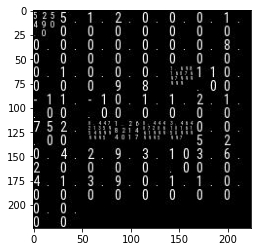

<IPython.core.display.Javascript object>

In [33]:
for image, label in labeled_train.take(1):
    print("Label: ", label.numpy())
    show_image(image.numpy(), IMAGE_SIZE, ONE_CHANNEL)

Label:  [ True False]


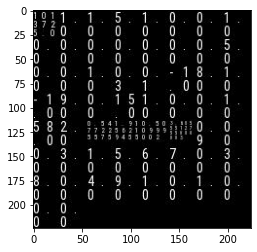

<IPython.core.display.Javascript object>

In [34]:
for image, label in labeled_valid.take(1):
    print("Label: ", label.numpy())
    show_image(image.numpy(), IMAGE_SIZE, ONE_CHANNEL)

In [35]:
# show_image(X_valid[0], IMAGE_SIZE, ONE_CHANNEL)

<IPython.core.display.Javascript object>

In [36]:
# show_image(X_test[0], IMAGE_SIZE, ONE_CHANNEL)

<IPython.core.display.Javascript object>

## Training model (transfer learning)

In [37]:
epochs_1 = 500
epochs_2 = 200
patience = 1

steps_per_epoch = np.ceil(train_indices.shape[0] / BATCH_SIZE)
steps_per_epoch_val = np.ceil(valid_indices.shape[0] / BATCH_SIZE)

<IPython.core.display.Javascript object>

### Creating model, using existing one

In [38]:
activation = mish
optimizer = Lookahead(RectifiedAdam(), sync_period=6, slow_step_size=0.5)

<IPython.core.display.Javascript object>

In [39]:
from tensorflow.keras.applications import (
    MobileNetV2,
    NASNetLarge,
    NASNetMobile,
    InceptionV3,
)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout,
)
from tensorflow.keras import backend as K

nb_channel = 1 if ONE_CHANNEL else 3
# create the base pre-trained model
# tf.keras.applications.NASNetMobile
# tf.keras.applications.NASNetLarge
# base_model = NASNetLarge( # IMAGE_SIZE must be 224
#    input_shape=(IMAGE_SIZE, IMAGE_SIZE, nb_channel),
#    weights="imagenet",
#    include_top=False,
# )

# base_model = NASNetLarge( # IMAGE_SIZE must be 331
#    input_shape=(IMAGE_SIZE, IMAGE_SIZE, nb_channel),
#    weights="imagenet",
#    include_top=False,
# )
base_model = MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, nb_channel),
    weights="imagenet",
    include_top=False,
)
# base_model = InceptionV3(
#     input_shape=(IMAGE_SIZE, IMAGE_SIZE, nb_channel),
#     weights="imagenet",
#     include_top=False,
# )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation=activation, kernel_initializer="he_normal")(x)
x = Dropout(0.3)(x)
# x = Dense(128, activation=activation, kernel_initializer="he_normal")(x)
# x = Dropout(0.2)(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation="softmax")(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# es.set_model(model)
# compile the model (should be done *after* setting layers to non-trainable)
es = EarlyStopping(
    monitor="val_loss",
    verbose=1,
    mode="min",
    patience=patience,
    restore_best_weights=True,
)
# We need to recompile the model for these modifications to take effect
es.set_model(model)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"])

<IPython.core.display.Javascript object>

### Fit new layers

In [40]:
%%time
# train the model on the new data for a few epochs
history_1 = model.fit(
    dataset_train, 
    callbacks=[es],
    epochs=epochs_1,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_valid,
    validation_steps=steps_per_epoch_val
)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Train for 7441.0 steps, validate for 931.0 steps
Epoch 1/500
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
7441/7441 [==============================] - 710s 95ms/step - loss: 0.1615 - AUC: 0.9655 - val_loss: 0.1575 - val_AUC: 0.9635
Epoch 2/500
7441/7441 [==============================] - 704s 95ms/step - loss: 0.1582 - AUC: 0.9674 - val_loss: 0.1614 - val_AUC: 0.9643
Epoch 3/500
7441/7441 [==============================] - 704s 95ms/step - loss: 0.1565 - AUC: 0.9694 - val_loss: 0.1582 - val_AUC: 0.9642
Epoch 4/500
7441/7441 [==============================] - 706s 95ms/step - loss: 0.1545 - AUC: 0.9715 - val_loss: 0.1812 - val_AUC: 0.9647
Epoch 5/500
7441/7441 [==============================] - 706s 95ms/step - loss: 0.1520 - AUC: 0.9737 - val_loss: 0.4237 - val_AUC: 0.9602
Epoch 6/500
7441/7441 [==============================] - 706s 95ms/step - loss: 0.1491 - AUC: 0.9757 - val_loss: 1.1154 - val_AUC: 0.0923
Epoch 7/500
7441/7441 [===================

<IPython.core.display.Javascript object>

### Unfreeze and fit more/all layers

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [42]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 Conv1_pad
2 Conv1
3 bn_Conv1
4 Conv1_relu
5 expanded_conv_depthwise
6 expanded_conv_depthwise_BN
7 expanded_conv_depthwise_relu
8 expanded_conv_project
9 expanded_conv_project_BN
10 block_1_expand
11 block_1_expand_BN
12 block_1_expand_relu
13 block_1_pad
14 block_1_depthwise
15 block_1_depthwise_BN
16 block_1_depthwise_relu
17 block_1_project
18 block_1_project_BN
19 block_2_expand
20 block_2_expand_BN
21 block_2_expand_relu
22 block_2_depthwise
23 block_2_depthwise_BN
24 block_2_depthwise_relu
25 block_2_project
26 block_2_project_BN
27 block_2_add
28 block_3_expand
29 block_3_expand_BN
30 block_3_expand_relu
31 block_3_pad
32 block_3_depthwise
33 block_3_depthwise_BN
34 block_3_depthwise_relu
35 block_3_project
36 block_3_project_BN
37 block_4_expand
38 block_4_expand_BN
39 block_4_expand_relu
40 block_4_depthwise
41 block_4_depthwise_BN
42 block_4_depthwise_relu
43 block_4_project
44 block_4_project_BN
45 block_4_add
46 block_5_expand
47 block_5_expand_BN
48 block_5_exp

<IPython.core.display.Javascript object>

In [43]:
# raise Exception("STOP")

<IPython.core.display.Javascript object>

In [44]:
# Let's unfreeze the whole model
for layer in model.layers:  # [1019:]:  # [293:]:
    layer.trainable = True
# Let's build an optimizer
optimizer = Lookahead(RectifiedAdam(), sync_period=6, slow_step_size=0.5)
es = EarlyStopping(
    monitor="val_loss",
    verbose=1,
    mode="min",
    patience=patience,
    restore_best_weights=True,
)
# We need to recompile the model for these modifications to take effect
es.set_model(model)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"])

<IPython.core.display.Javascript object>

In [45]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_2 = model.fit(
    dataset_train,
    callbacks=[es],
    epochs=epochs_2,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_valid,
    validation_steps=steps_per_epoch_val,
)

Train for 7441.0 steps, validate for 931.0 steps
Epoch 1/200
7441/7441 [==============================] - 2948s 396ms/step - loss: 0.1563 - AUC: 0.9687 - val_loss: 0.1836 - val_AUC: 0.9686
Epoch 2/200
7441/7441 [==============================] - 2921s 393ms/step - loss: 0.1553 - AUC: 0.9699 - val_loss: 0.1556 - val_AUC: 0.9707
Epoch 3/200
7441/7441 [==============================] - 2925s 393ms/step - loss: 0.1544 - AUC: 0.9709 - val_loss: 0.1547 - val_AUC: 0.9718
Epoch 4/200
7441/7441 [==============================] - 2924s 393ms/step - loss: 0.1540 - AUC: 0.9714 - val_loss: 0.1537 - val_AUC: 0.9720
Epoch 5/200
7441/7441 [==============================] - 2925s 393ms/step - loss: 0.1536 - AUC: 0.9719 - val_loss: 0.1536 - val_AUC: 0.9720
Epoch 6/200
7441/7441 [==============================] - 2924s 393ms/step - loss: 0.1534 - AUC: 0.9721 - val_loss: 0.1542 - val_AUC: 0.9720
Epoch 7/200
7441/7441 [==============================] - 2942s 395ms/step - loss: 0.1531 - AUC: 0.9724 - val_lo

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
plot_metric(history_2, "loss")

In [ ]:
plot_metric(history_2, "AUC")

## Evaluation

In [46]:
X_test = preprocess_data(
    X[test_indices], fixed_text_to_square_image, IMAGE_SIZE, ONE_CHANNEL
)
Y_test = Y[test_indices]

Input shape is (59521, 58)
Output data is estimated to 8544.5185546875 Mo in RAM


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
preds_test = model.predict(X_test)
print(roc_auc_score(Y_test, preds_test[:, 1]))

## Explainability

In [ ]:
# https://medium.com/google-developer-experts/interpreting-deep-learning-models-for-computer-vision-f95683e23c1d

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

In [ ]:
!pip install shap

In [ ]:
# import keras
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input, decode_predictions
# from matplotlib.colors import LinearSegmentedColormap
# import numpy as np
import shap

# import keras.backend as K
# import json

shap.initjs()


# utility function to visualize SHAP values in larger image formats
# this modifies the `shap.image_plot(...)` function
def visualize_model_decisions(shap_values, x, labels=None, figsize=(20, 30)):

    colors = []
    for l in np.linspace(1, 0, 100):
        colors.append((30.0 / 255, 136.0 / 255, 229.0 / 255, l))
    for l in np.linspace(0, 1, 100):
        colors.append((255.0 / 255, 13.0 / 255, 87.0 / 255, l))
    red_transparent_blue = LinearSegmentedColormap.from_list(
        "red_transparent_blue", colors
    )

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert (
            labels.shape[0] == shap_values[0].shape[0]
        ), "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(
                shap_values
            ), "Labels must have a column for each output in shap_values!"
        else:
            assert (
                len(labels.shape) == 1
            ), "Labels must be a vector for single output shap_values."

    # plot our explanations
    fig_size = figsize
    fig, axes = plt.subplots(
        nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size
    )
    if len(axes.shape) == 1:
        axes = axes.reshape(1, axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.0

        axes[row, 0].imshow(x_curr)
        axes[row, 0].axis("off")

        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (
                0.2989 * x_curr[:, :, 0]
                + 0.5870 * x_curr[:, :, 1]
                + 0.1140 * x_curr[:, :, 2]
            )  # rgb to gray
        else:
            x_curr_gray = x_curr

        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack(
                [np.abs(shap_values[i]) for i in range(len(shap_values))], 0
            ).flatten()
        else:
            abs_vals = np.stack(
                [np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0
            ).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row, i + 1].set_title(labels[row, i])
            sv = (
                shap_values[i][row]
                if len(shap_values[i][row].shape) == 2
                else shap_values[i][row].sum(-1)
            )
            axes[row, i + 1].imshow(
                x_curr_gray,
                cmap=plt.get_cmap("gray"),
                alpha=0.15,
                extent=(-1, sv.shape[0], sv.shape[1], -1),
            )
            im = axes[row, i + 1].imshow(
                sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val
            )
            axes[row, i + 1].axis("off")

    cb = fig.colorbar(
        im,
        ax=np.ravel(axes).tolist(),
        label="SHAP value",
        orientation="horizontal",
        aspect=fig_size[0] / 0.2,
    )
    cb.outline.set_visible(False)

In [ ]:
# make model predictions
n_layer = 311


def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x]))
    return K.get_session().run(model.layers[layer].input, feed_dict)


e = shap.GradientExplainer(
    (model.layers[n_layer].input, model.layers[-1].output),
    map2layer(preprocess_input(X.copy()), n_layer),
)
shap_values, indexes = e.shap_values(map2layer(to_predict, n_layer), ranked_outputs=2)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
print(index_names)
# visualize model decisions
visualize_model_decisions(
    shap_values=shap_values, x=to_predict, labels=index_names, figsize=(20, 40)
)